<a href="https://colab.research.google.com/github/NunezKant/COVID19_MEX_MASTER/blob/master/Bayesian_fit_SEIR_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc3==3.8

%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

In [0]:
def SEIR(y, t, p):
    ds = -p[1]*y[0]*y[2]
    de = p[1]*y[0]*y[2] - p[0]*y[1]
    di = p[0]*y[1] - p[2]*y[2]
    dr = p[2]*y[2]
    return [ds, de, di, dr]

In [0]:
np.random.seed(666)

alpha = 0.2
beta = 1.75
gamma = 0.5
#theta = 1.0

#params = alpha, beta, gamma
times = np.arange(0,90,1) # 90 dias
#times

## Condiciones iniciales (porcentuales)
Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

## Curva de modelo
y = odeint(SEIR,t=times,y0=[S_o,E_o,I_o,R_o], args=((alpha, beta, gamma),), rtol=1e-08)

## Curva de observaciones
#22 de Marzo: 32
#23 de Marzo: 48
#24 de Marzo: 52
#25 de Marzo: 57
#26 de Marzo: 60
#27 de Marzo: 63 (interpolación manual)
#28 de Marzo: 66
#29 de Marzo: 70 + 39 privados: 109 (pendiente)

yobs = np.array([ 32, 48, 52, 57, 60, 63, 66, 70 ])
#yobs_norm = yobs / Pop
#print([S_o,E_o,I_o,R_o]*Pop)

In [4]:
Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

def SEIR_Day(i,r):
  """ 
  Produce los datos normalizados de S,E,I,R dados I y R del dia.
  Los expuestos se calcula como 4 veces los infectados
  """
  I = i / Pop
  E = (i*4) / Pop # Ojo aca con el 4
  S = 1 - (E*I)
  R = r / Pop
  return [S, E, I, R]

## Crear un arreglo de N x 4 para enviar como estados al sistema
yobs_arr = np.array([ SEIR_Day(y,0) for y in yobs ])

"""
yobs = np.array([
    SEIR_Day(32,0),
    SEIR_Day(48,0),
    SEIR_Day(52,0),
    SEIR_Day(57,0),
    SEIR_Day(60,0)
  ]
)
"""
yobs_arr

array([[1.00000000e+00, 3.02958580e-05, 7.57396450e-06, 0.00000000e+00],
       [9.99999999e-01, 4.54437870e-05, 1.13609467e-05, 0.00000000e+00],
       [9.99999999e-01, 4.92307692e-05, 1.23076923e-05, 0.00000000e+00],
       [9.99999999e-01, 5.39644970e-05, 1.34911243e-05, 0.00000000e+00],
       [9.99999999e-01, 5.68047337e-05, 1.42011834e-05, 0.00000000e+00],
       [9.99999999e-01, 5.96449704e-05, 1.49112426e-05, 0.00000000e+00],
       [9.99999999e-01, 6.24852071e-05, 1.56213018e-05, 0.00000000e+00],
       [9.99999999e-01, 6.62721893e-05, 1.65680473e-05, 0.00000000e+00]])

In [5]:
obs_times=np.arange(0,yobs_arr.shape[0],1)
obs_times

array([0, 1, 2, 3, 4, 5, 6, 7])

In [0]:
seir_model = DifferentialEquation(
    func=SEIR,
    times=obs_times,
    n_states=4,
    n_theta=3,
)

# CON GAMMA FIJA = 0.5

In [8]:
# alpha = 0.2 , valor teorico
# gamma = 0.5 , valor teorico
# beta = 1.75 , Valor teorico para R de 3.5
# RO = 3.5  , Valor teorico para epidemia alta

with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 2.5e-6, shape=4) #1e-3 para 4.2M de habitantes son 4.2 casos
    p_alpha = pm.Bound(pm.Normal, lower=0, upper=1)("alpha",.5, 0.3 )  
    #p_gamma = pm.Bound(pm.Normal, lower=0, upper=1)("gamma",gamma, 0.25 )  
    R0 = pm.Bound(pm.Normal, lower=1, upper=4)('R0', 3.5, 1.75)
    p_beta = pm.Deterministic('beta', gamma*R0)

    seir_curves = seir_model(y0=[S_o,E_o,I_o,R_o], theta=[p_alpha, p_beta, gamma])
    Y = pm.Normal('Y', mu=seir_curves, sd=sigma, observed=yobs_arr)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000,tune=500, target_accept=0.95)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R0, alpha, sigma]
100%|██████████| 2000/2000 [00:59<00:00, 33.44it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f890b393e48>,
      dtype=object)

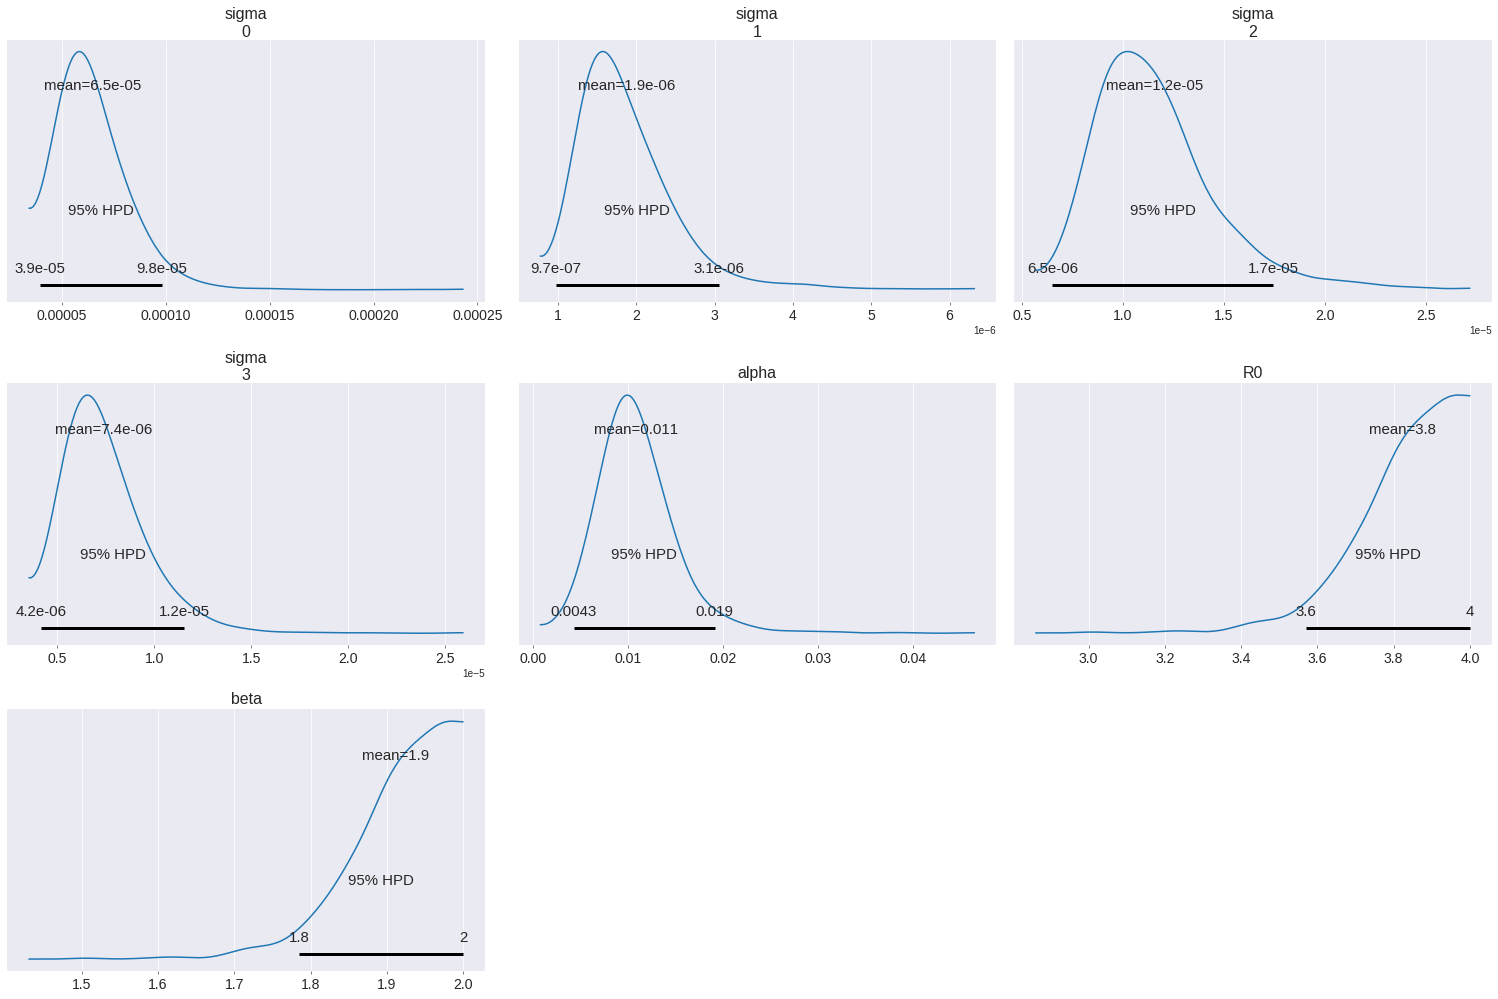

In [9]:
az.plot_posterior(data,round_to=2, credible_interval=0.95)

# CON ALPHA FIJA = 0.2

In [7]:
with pm.Model() as model5:
    sigma = pm.HalfCauchy('sigma', 2.5e-6, shape=4) #1e-3 para 4.2M de habitantes son 4.2 casos
    #p_alpha = pm.Bound(pm.Normal, lower=0, upper=1)("alpha",.5, 0.3 )  
    p_gamma = pm.Bound(pm.Normal, lower=0, upper=1)("gamma",.5, 0.37 )  
    R0 = pm.Bound(pm.Normal, lower=1, upper=5)('R0', 3.5, 1)
    p_beta = pm.Deterministic('beta', gamma*R0)

    alpha = 0.2
    seir_curves = seir_model(y0=[S_o,E_o,I_o,R_o], theta=[alpha, p_beta, p_gamma])
    Y = pm.Normal('Y', mu=seir_curves, sd=sigma, observed=yobs_arr)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000,tune=500, target_accept=0.95)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R0, gamma, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [36:32<00:00,  1.46s/it]
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 2000/2000 [01:04<00:00, 30.93it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0495773748>,
      dtype=object)

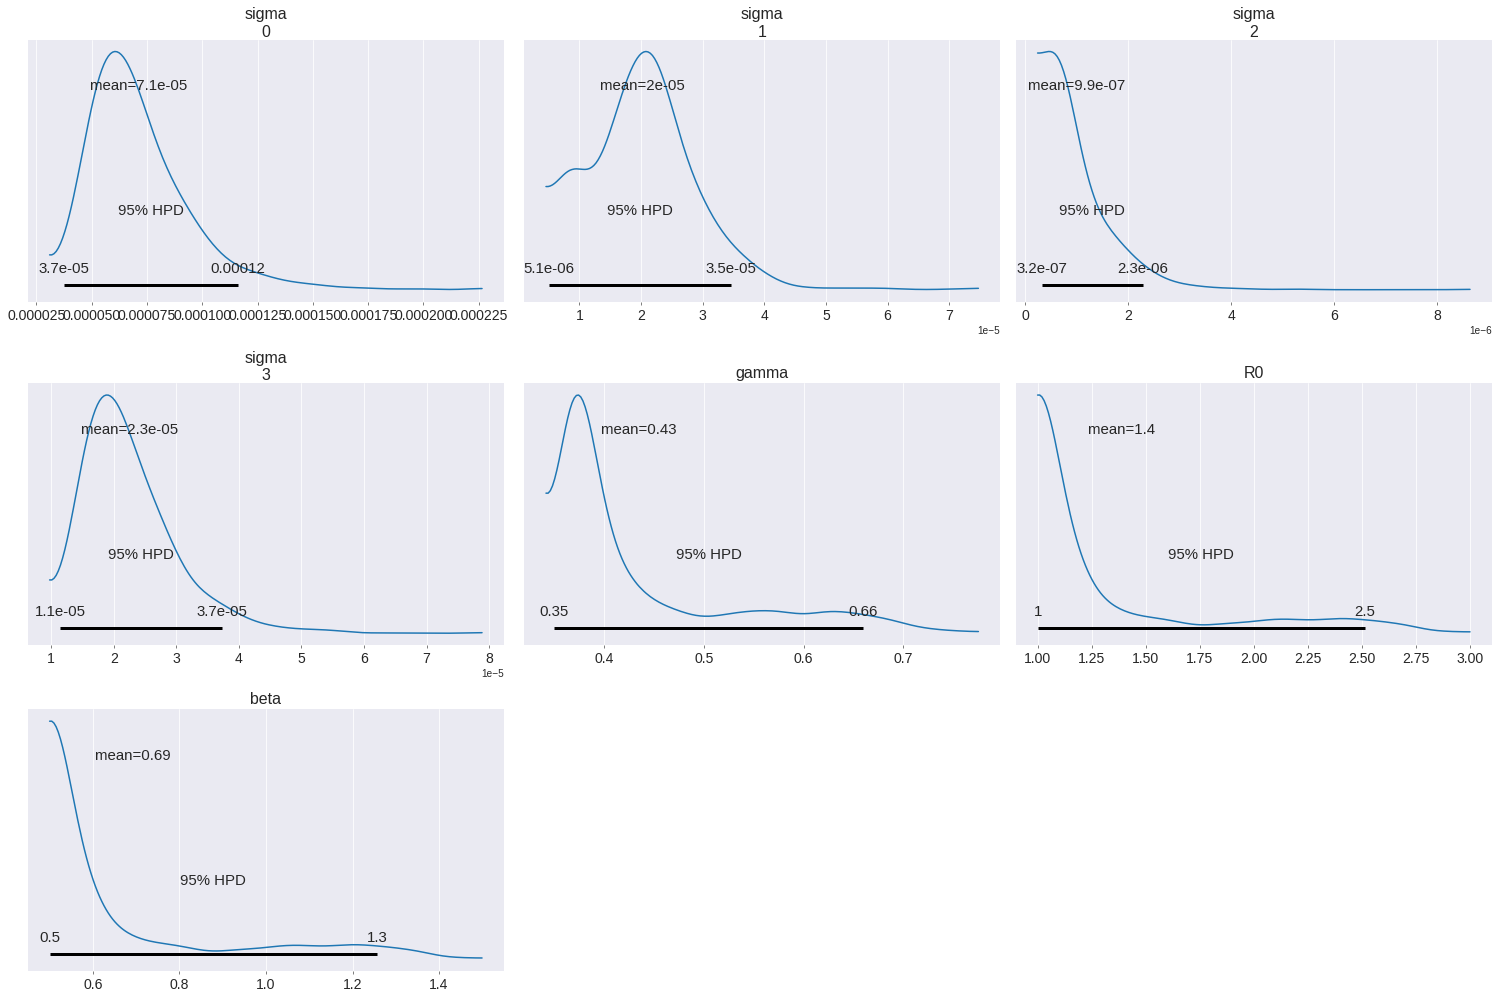

In [8]:
az.plot_posterior(data,round_to=2, credible_interval=0.95)

In [0]:
ppc_samples = posterior_predictive["Y"]

In [0]:
ppc_samples = posterior_predictive["Y"]
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)

In [11]:
mean_ppc.shape

(8, 4)

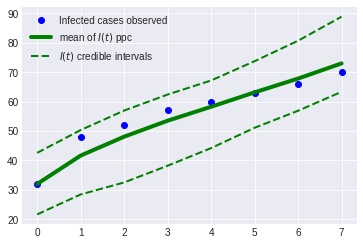

In [12]:
plt.plot(obs_times,yobs,'o', color='b', lw=1, label='Infected cases observed')
plt.plot(obs_times,mean_ppc[:,2]*Pop, color='g', lw=4, label=f'mean of $I(t)$ ppc')
plt.plot(obs_times,CriL_ppc[:,2]*Pop, '--',  color='g', lw=2, label=f'$I(t)$ credible intervals')
plt.plot(obs_times,CriU_ppc[:,2]*Pop, '--',  color='g', lw=2)
plt.legend()

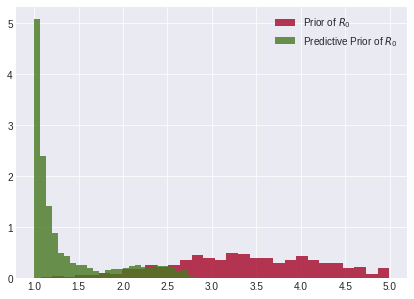

In [14]:
plt.figure(figsize = (7,5))
plt.hist(prior["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $R_0$",color = "#A60628", density = True)
plt.hist(trace["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $R_0$",color = "#467821", density = True)
plt.legend()

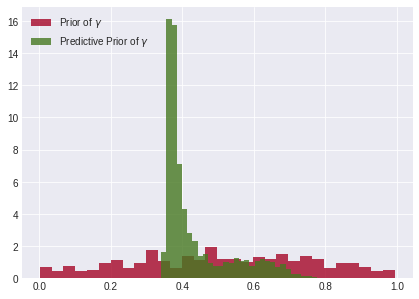

In [16]:
plt.figure(figsize = (7,5))
plt.hist(prior["gamma"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $\gamma$",color = "#A60628", density = True)
plt.hist(trace["gamma"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $\gamma$",color = "#467821", density = True)
plt.legend()